In [2]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [3]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

 ········


In [4]:
pip install -qU langchain-cohere

Note: you may need to restart the kernel to use updated packages.


In [5]:
import getpass
import os

if not os.environ.get("COHERE_API_KEY"):
  os.environ["COHERE_API_KEY"] = getpass.getpass("Enter API key for Cohere: ")

from langchain_cohere import ChatCohere

llm = ChatCohere(model="command-r-plus")

Enter API key for Cohere:  ········


In [6]:
import getpass
import os

if not os.environ.get("COHERE_API_KEY"):
  os.environ["COHERE_API_KEY"] = getpass.getpass("Enter API key for Cohere: ")

from langchain_cohere import CohereEmbeddings

embeddings = CohereEmbeddings(model="embed-english-v3.0")

In [5]:
pip install -qU langchain-pinecone

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [7]:
os.environ["PINECONE_API_KEY"] = getpass.getpass()

 ········


In [21]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone()
index_name = "react-demo"

pc.create_index(
    name=index_name,
    dimension=1024, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

index = pc.Index(index_name)

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

In [22]:
os.environ["USER_AGENT"] = "agent"

In [31]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=('https://react.dev/blog/2024/12/05/react-19',),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("page-content", "title")
        )
    ),

)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [39]:
response = graph.invoke({"question": "What are the new updates added to the react new version? answer in 50 words"})
print(response["answer"])

React 19 introduces pre-warming for suspended trees, improving Suspense functionality, and new React DOM static APIs.


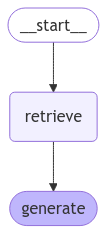

In [37]:
graph

In [35]:
llm.invoke("what is the current react version runnning?").content

'The current major version of React is React 18, which was released on March 29, 2022. This version introduced several new features and improvements, including:\n\n1. Concurrent Features: React 18 brings the ability to start working on concurrent features, which means React can now work on multiple tasks simultaneously, improving the overall performance and responsiveness of your application.\n\n1. Suspense and Streaming Server Rendering: Suspense allows React components to "wait" for something before rendering, enabling better handling of asynchronous operations like data fetching. Streaming Server Rendering improves the user experience by sending the initial HTML to the browser sooner.\n\n1. New APIs: React 18 comes with new APIs like startTransition and useId. startTransition helps you control when updates are applied, enabling better control over the timing of state updates. useId is a new hook that provides a unique ID for accessibility needs.\n\n1. Improved Server Components: Ser